# Multi-armed Bandits

In [1]:
from functools import partial
import numpy
from matplotlib import pyplot
import seaborn

In [2]:
seaborn.set_style('ticks')

## 10-armed Testbed

In [3]:
# 2000 randomly generated 10-armed bandit problems
k = 10
n = 2000

# means of action values are selected from normal
# distribution with mean 0 and variance 1
action_values = numpy.random.randn(n, k)
action_values.shape

(2000, 10)

Text(0,0.5,'reward distribution')

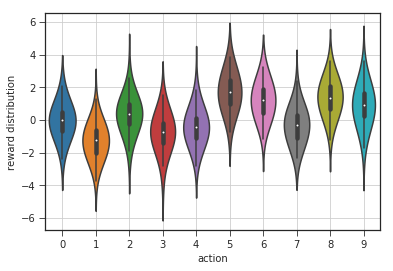

In [4]:
# a 10-armed bandit problem
#
# when an action is applied the reward is
# selected from a normal distribution with corresponding
# action value mean and variance 1
action_values_sample = action_values[0] + numpy.random.randn(128, k)
ax = seaborn.violinplot(data=action_values_sample, bw=1)
ax.grid()
ax.set_xlabel('action')
ax.set_ylabel('reward distribution')

In [5]:
class Bandit:
    def __init__(self, action_values):
        self.action_values = action_values
        
    def __call__(self, a):
        """Take an action a and return a corresponding reward R."""
        return numpy.random.randn() + self.action_values[a]

## Sample-average

In [6]:
def sample_average(bandit, time_steps):
    Q = numpy.zeros(k)  # estimate of action values
    N = numpy.zeros(k, dtype=numpy.int)  # action selections
    As = numpy.zeros(time_steps, dtype=numpy.int)  # actions history
    Rs = numpy.zeros(time_steps)  # rewards history

    for t in range(time_steps):
        # select action
        A = numpy.argmax(Q)
        As[t] = A
        # recieve reward
        R = bandit(A)
        Rs[t] = R
        # update estimated action's value
        N[A] += 1
        Q[A] += (R - Q[A]) / N[A]

    return As, Rs

In [7]:
def evaluate_method(method, Bandit, action_values=action_values, time_steps=1000):
    n = len(action_values)
    Ass = numpy.zeros((n, time_steps), dtype=numpy.int)
    Rss = numpy.zeros((n, time_steps))

    for i, av in enumerate(action_values):
        Ass[i], Rss[i] = method(Bandit(av), time_steps)
    
    return Ass, Rss

sample_average_data = evaluate_method(sample_average, Bandit)

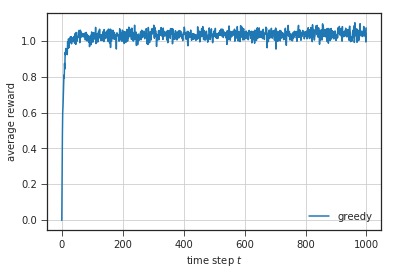

In [8]:
def plot_average_reward(Rss, ax, label):
    ax.plot(Rss.mean(axis=0), label=label)
    ax.set_xlabel('time step $t$')
    ax.set_ylabel('average reward')
    ax.grid(True)
    ax.legend()

plot_average_reward(sample_average_data[1], pyplot.subplot(), 'greedy')

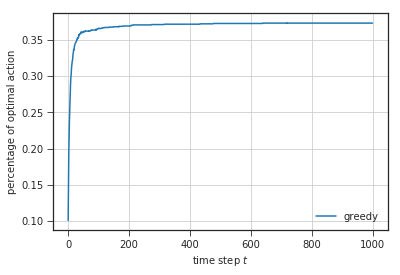

In [9]:
def plot_optimal_action(Ass, ax, label, action_values=action_values):
    optimal_As = action_values.argmax(axis=1).reshape(-1, 1)
    ax.plot(numpy.sum(Ass == optimal_As, axis=0) / len(Ass), label=label)
    ax.set_xlabel('time step $t$')
    ax.set_ylabel('percentage of optimal action')
    ax.grid(True)
    ax.legend()

plot_optimal_action(sample_average_data[0], pyplot.subplot(), 'greedy')

## Epsilon Greedy

In [10]:
def epsilon_greedy(bandit, time_steps, epsilon):
    Q = numpy.zeros(k)  # estimate of action values
    N = numpy.zeros(k, dtype=numpy.int)  # action selections
    As = numpy.zeros(time_steps, dtype=numpy.int)  # actions history
    Rs = numpy.zeros(time_steps)  # rewards history

    for t in range(time_steps):
        # select action
        if numpy.random.rand() < 1 - epsilon:
            A = numpy.argmax(Q)
        else:
            A = numpy.random.randint(0, k)
        As[t] = A
        # recieve reward
        R = bandit(A)
        Rs[t] = R
        # update estimated action's value
        N[A] += 1
        Q[A] += (R - Q[A]) / N[A]

    return As, Rs

In [11]:
epsilon_greedy_01_data = evaluate_method(
    partial(epsilon_greedy, epsilon=0.1), Bandit
)

epsilon_greedy_001_data = evaluate_method(
    partial(epsilon_greedy, epsilon=0.01), Bandit
)

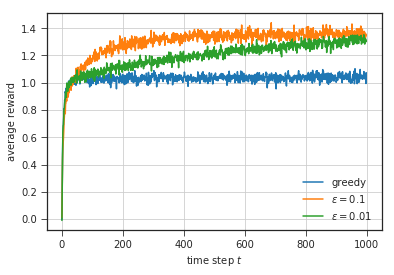

In [12]:
ax = pyplot.subplot()
plot_average_reward(sample_average_data[1], ax, 'greedy')
plot_average_reward(epsilon_greedy_01_data[1], ax, r'$\varepsilon = 0.1$')
plot_average_reward(epsilon_greedy_001_data[1], ax, r'$\varepsilon = 0.01$')

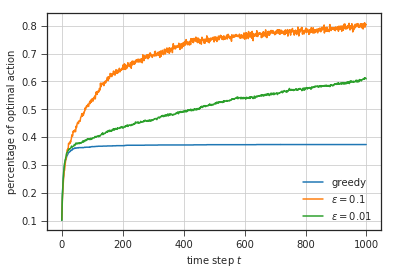

In [13]:
ax = pyplot.subplot()
plot_optimal_action(sample_average_data[0], ax, 'greedy')
plot_optimal_action(epsilon_greedy_01_data[0], ax, r'$\varepsilon = 0.1$')
plot_optimal_action(epsilon_greedy_001_data[0], ax, r'$\varepsilon = 0.01$')

## Nonstationary Problem

In [14]:
class NonstationaryBandit:
    def __init__(self, action_values):
        self.action_values = action_values
        
    def __call__(self, a):
        """Take an action a and return a corresponding reward R."""
        self.action_values += 0.01 * numpy.random.randn(k)
        return numpy.random.randn() + self.action_values[a]

In [15]:
def exponential_recency_weighted_average(bandit, time_steps, epsilon, step_size):
    Q = numpy.zeros(k)  # estimate of action values
    As = numpy.zeros(time_steps, dtype=numpy.int)  # actions history
    Rs = numpy.zeros(time_steps)  # rewards history

    for t in range(time_steps):
        # select action
        if numpy.random.rand() < 1 - epsilon:
            A = numpy.argmax(Q)
        else:
            A = numpy.random.randint(0, k)
        As[t] = A
        # recieve reward
        R = bandit(A)
        Rs[t] = R
        # update estimated action's value
        Q[A] += step_size * (R - Q[A])

    return As, Rs

In [16]:
time_steps = 10000

nonstationary_epsilon_greedy_data = evaluate_method(
    partial(epsilon_greedy, epsilon=0.1),
    NonstationaryBandit,
    time_steps=time_steps
)
nonstationary_decay_data = evaluate_method(
    partial(exponential_recency_weighted_average,
            epsilon=0.1, step_size=0.1),
    NonstationaryBandit,
    time_steps=time_steps
)

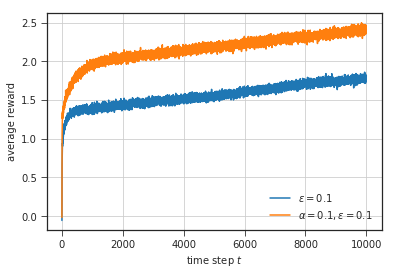

In [17]:
ax = pyplot.subplot()
plot_average_reward(nonstationary_epsilon_greedy_data[1], ax, r'$\varepsilon = 0.1$')
plot_average_reward(nonstationary_decay_data[1], ax, r'$\alpha = 0.1, \varepsilon = 0.1$')

## Optimistic Initial Values

In [18]:
def optimistic_initial_values(bandit, time_steps, epsilon, step_size, init):
    Q = numpy.full(k, init, dtype=numpy.float)  # estimate of action values
    As = numpy.zeros(time_steps, dtype=numpy.int)  # actions history
    Rs = numpy.zeros(time_steps)  # rewards history

    for t in range(time_steps):
        # select action
        if numpy.random.rand() < 1 - epsilon:
            A = numpy.argmax(Q)
        else:
            A = numpy.random.randint(0, k)
        As[t] = A
        # recieve reward
        R = bandit(A)
        Rs[t] = R
        # update estimated action's value
        Q[A] += step_size * (R - Q[A])

    return As, Rs

In [19]:
optimistic_data = evaluate_method(
    partial(optimistic_initial_values, epsilon=0, step_size=0.1, init=5),
    Bandit
)
realistic_data = evaluate_method(
    partial(optimistic_initial_values, epsilon=0.1, step_size=0.1, init=0),
    Bandit
)

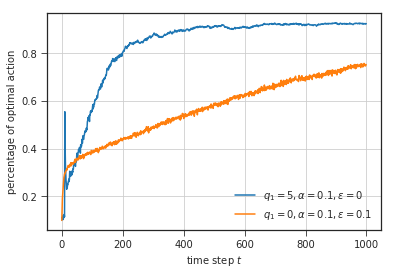

In [20]:
ax = pyplot.subplot()
plot_optimal_action(optimistic_data[0], ax,
                    r'$q_1 = 5, \alpha = 0.1, \varepsilon = 0$')
plot_optimal_action(realistic_data[0], ax,
                    r'$q_1 = 0, \alpha = 0.1, \varepsilon = 0.1$')

## Upper-confidence-bound

In [21]:
def upper_confidence_bound(bandit, time_steps, step_size, c):
    Q = numpy.zeros(k)  # estimate of action values
    N = numpy.zeros(k, dtype=numpy.int)  # estimate of action values
    As = numpy.zeros(time_steps, dtype=numpy.int)  # actions history
    Rs = numpy.zeros(time_steps)  # rewards history

    for t in range(time_steps):
        # select action
        A = numpy.argmax(Q + c * numpy.sqrt(numpy.log1p(t) / (N + 1)))
        N[A] += 1
        As[t] = A
        # recieve reward
        R = bandit(A)
        Rs[t] = R
        # update estimated action's value
        Q[A] += step_size * (R - Q[A])

    return As, Rs

In [22]:
ucb_data = evaluate_method(
    partial(upper_confidence_bound, step_size=0.1, c=2),
    Bandit
)

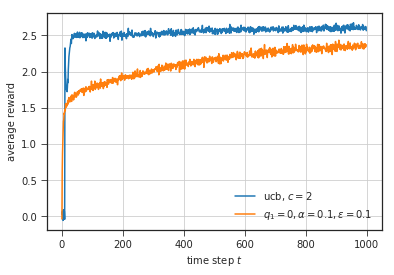

In [23]:
ax = pyplot.subplot()
plot_average_reward(ucb_data[1], ax, r'ucb, $c = 2$')
plot_average_reward(realistic_data[1], ax,
                    r'$q_1 = 0, \alpha = 0.1, \varepsilon = 0.1$')

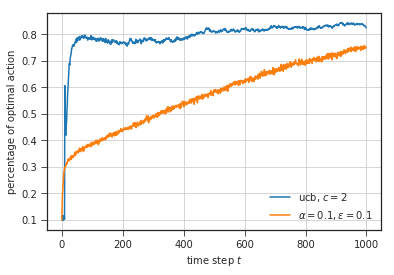

In [24]:
ax = pyplot.subplot()
plot_optimal_action(ucb_data[0], ax, r'ucb, $c = 2$')
plot_optimal_action(realistic_data[0], ax,
                    r'$\alpha = 0.1, \varepsilon = 0.1$')